# Image Segmentation using deep learning technique on 3D Meshes

Installing the required packages

In [142]:
!pip show numpy

Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: c:\users\antho\anaconda3\lib\site-packages
Requires: 
Required-by: Bottleneck, gym, h5py, Keras-Preprocessing, matplotlib, missingno, mkl-fft, mkl-random, numexpr, opt-einsum, pandas, scikit-learn, scipy, seaborn, tensorboard, tensorflow, torch_geometric, torchvision, trimesh


In [143]:
from time import sleep
from pathlib import Path
from itertools import tee
from functools import lru_cache
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D  
import trimesh
import math
from scipy.integrate import simpson
from numpy import trapz
from matplotlib import patches
import os
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.transforms import BaseTransform, Compose, FaceToEdge
from torch_geometric.data import Data, InMemoryDataset, extract_zip, DataLoader

In [144]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [145]:
def load_mesh(mesh_filename: Path):
    """Extract vertices and faces from raw mesh file.

    Parameters
    ----------
    mesh_filename: PathLike
        Path to mesh `.ply` file.

    Returns
    -------
    vertices: torch.tensor
        Float tensor of size (|V|, 3), where each row
        specifies the spatial position of a vertex in 3D space.
    faces: torch.tensor
        Intger tensor of size (|M|, 3), where each row
        defines a traingular face.
    """
    mesh = trimesh.load_mesh(mesh_filename, process=False)
    vertices = torch.from_numpy(mesh.vertices).to(torch.float)
    faces = torch.from_numpy(mesh.faces)
    faces = faces.t().to(torch.long).contiguous()
    return vertices, faces

In [146]:
def get_mlp_layers(channels: list, activation, output_activation=nn.Identity):
    """Define basic multilayered perceptron network."""
    layers = [nn.Flatten(),]
    *intermediate_layer_definitions, final_layer_definition = pairwise(channels)

    for in_ch, out_ch in intermediate_layer_definitions:
        intermediate_layer = nn.Linear(in_ch, out_ch)
        layers += [intermediate_layer, activation()]

    layers += [nn.Linear(*final_layer_definition), output_activation()]
    return nn.Sequential(*layers)

In [147]:
@torch.no_grad()
def visualize_prediction(net, data, device, map_seg_id_to_color):
    """Visualization of predicted segmentation mask.""" 
    def _map_seg_label_to_color(seg_ids, map_seg_id_to_color):
        return torch.vstack(
            [map_seg_id_to_color[int(seg_ids[idx])] for idx in range(seg_ids.shape[0])]
        )

    data = data.to(device)
    predictions = net(data)
    predicted_seg_labels = predictions.argmax(dim=-1)
    mesh_colors = _map_seg_label_to_color(predicted_seg_labels, map_seg_id_to_color)
    faces_group = []
    for id in range(len(predicted_seg_labels)):
      # print(predicted_seg_labels[idx])
      if predicted_seg_labels[id] != 0 :
        faces_group.append(True)
      else:
        faces_group.append(False)
    segmented_mesh = trimesh.base.Trimesh(
        vertices=data.x.cpu().numpy(),
        faces=data.face.t().cpu().numpy(),
        process=False,
    )
    segmented_mesh.visual.vertex_colors = mesh_colors.cpu().numpy()
    
    return segmented_mesh, faces_group

In [148]:
# Favourite Models = 10, 20
segmented_mesh = trimesh.load('Segmented 3D data/model_040_segmented.ply') # 'cs1_segmented.ply'

In [149]:
box = trimesh.primitives.Box(extents=[1, 1, 0.25])
# box.transform
result = segmented_mesh.slice_plane(box.facets_origin, -box.facets_normal)
# result.show()
interset_mesh = trimesh.intersections.slice_mesh_plane(segmented_mesh, [0,0,1],result.vertices[0])
interset_mesh.show()

In [150]:
interset_mesh1 = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,1,0], interset_mesh.centroid)
#interset_mesh1.show()

In [151]:
interset_mesh2 = trimesh.intersections.slice_mesh_plane(interset_mesh1, [0,0,1], interset_mesh1.centroid)
#interset_mesh2.show()

In [152]:
interset_mesh3 = trimesh.intersections.slice_mesh_plane(interset_mesh2, [0,0,1], interset_mesh2.centroid)
#interset_mesh3.show()

In [153]:
inter = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,0,1], interset_mesh.centroid * 1.2)
#inter.show()

In [154]:
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()
    
    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle
    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return patches.Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = angle)

In [155]:
def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][0] + vertices[-1][0]) / 2.0

    #print x_width, y_width

    separation_radius = max(x_width/2.0, y_width/2.0)

    return angle

In [156]:
# [0.293739, -0.442647, 0.358117]
def get_XY(curves=""):
  pct = trimesh.points.PointCloud(interset_mesh.vertices)
  pointus = trimesh.points.plane_fit(pct.vertices)
  interset_mesh1 = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,1,0], pointus[0])
  intersss = trimesh.intersections.slice_mesh_plane(interset_mesh1, [0,0,1], pointus[0])
  intresss1 = trimesh.intersections.slice_mesh_plane(intersss, [0,1,0], pointus[0])
  pct1 = trimesh.points.PointCloud(intresss1.vertices)
  pointus1 = trimesh.points.plane_fit(pct1.vertices)
  intersss2 = trimesh.intersections.slice_mesh_plane(intresss1, [0,1,1], pointus1[0])
  pct2 = trimesh.points.PointCloud(intersss2.vertices)
  pointus2 = trimesh.points.plane_fit(pct2.vertices)

  if curves == "muscle":
    slice =  intersss.section(plane_origin=pointus1[0], 
                     plane_normal=[0,0,1])
  elif curves == "top":
    slice = intersss.section(plane_origin=pointus2[0], 
                     plane_normal=[0,0,1])
    
  slice_2D, to_3D = slice.to_planar()
  x = slice_2D.vertices[:,0]
  y = slice_2D.vertices[:,1]
  
  yvalue = x > slice_2D.centroid[0]
  y1value = x < slice_2D.centroid[0]
  y1 = y[y1value]
  x1 = x[y1value]
  x = x[yvalue]
  y = y[yvalue]
  ymax = max(y)
  y1max = max(y1)
  ymin = min(y)
  y1min = min(y1)
  # y1 = set(y)
  xpos = np.where(y == ymax)
  x1pos = np.where(y1 == y1max)
  xmax = x[xpos]
  x1max = x1[x1pos]
  # Compute the area using the composite trapezoidal rule.
  return x,y,x1,y1,xmax,x1max,ymin,ymax,y1min,y1max,slice_2D

In [157]:
def get_curves(curves =""):
  ax = plt.gca()
  x,y,x1,y1,xmax,x1max,ymin,ymax,y1min,y1max,slice_2D = get_XY(curves)
  if curves == "muscle" or curves == "top":
    line_3 = Line2D([slice_2D.centroid[0],x1max] , [y1min,y1max],linewidth=1, linestyle = "-", color="green")
  elif curves == 'back' :
    line_3 = Line2D([slice_2D.centroid[0],x1max] , [ymin,y1max],linewidth=1, linestyle = "-", color="green")
  area = trapz(y, dx=5)
  area1 = trapz(y1, dx=5)
  print("AUC of right muscle using Trapezoidal rule =", area)
  print("AUC of left muscle using Trapezoidal rule =", area1)

  # Compute the area using the composite Simpson's rule.
  area = simpson(y, dx=5)
  area1 = simpson(y1, dx=5)
  print("AUC of right muscle using Simpson's rule =", area)
  print("AUC of left muscle using Simpson's rule =", area1)
  line_1 = Line2D([slice_2D.centroid[0],xmax], [ymin,ymax], linewidth=1, linestyle = "-", color="green")
    # line_2 = Line2D([0,4.5], [0,3], linewidth=1, linestyle = "-", color="red")
  line_4 = ax.axvline(x=slice_2D.centroid[0], color='r')
  line_2 = ax.axhline(y=ymin, color='r')
  # line_3 = Line2D([slice_2D.centroid[0],x1max] , [y1min,y1max],linewidth=1, linestyle = "-", color="green")
  ax.add_line(line_1)
  ax.add_line(line_2)
  ax.add_line(line_3)
  angle_plot = get_angle_plot(line_1, line_2, 1)
  angle_plot1 = get_angle_plot(line_4,line_3, 1)
  angle_text = get_angle_text(angle_plot) 
  angle_text1 = get_angle_text(angle_plot1)
  minus_angle = float(90) - float(angle_text1)
    # ax.add_patch(angle_plot) # To display the angle arc
    # ax.text(*angle_text)
  angle_text = "%0.2f"%float(angle_text)+u"\u00b0" # Display angle upto 2 decimal places
  minus_angle_text = "%0.2f"%float(minus_angle)+u"\u00b0"
  text= "{} ".format(angle_text)
  text1 = "{}".format(minus_angle_text)
  ax.annotate(text,
              xy=(xmax, ymax), xycoords='data',
              xytext=(xmax, ymax), textcoords='offset points')
  ax.annotate(text1, xy=(x1max, y1max), xycoords='data', xytext=(x1max, y1max), textcoords='offset points')
  slice_2D.show()


In [158]:
def rotate_vector(vec, rotation_degrees, rotation_axis):
    # Function that turns a vector a given angle about a given axis
    rotation_radians = np.radians(rotation_degrees)
    rotation_vector = rotation_radians * rotation_axis
    rotation = R.from_rotvec(rotation_vector)
    rotated_vec = rotation.apply(vec)
    return rotated_vec

# Turn all vertices by 90deg around the x-axis

def rotated_vertices(vert,fa,degrees,axis):
  new_vert = []
  for v in vert:
    new_vert.append(rotate_vector(v,degrees,axis))
  # Create the mesh
  mesh_rot = trimesh.Trimesh(vertices= new_vert,
                       faces=fa)
  return mesh_rot


def rotated_back_slice():
  ax = plt.gca()
  rot_mesh =rotated_vertices(interset_mesh.vertices,interset_mesh.faces,290,np.array([0,1,0]))
  rot_mesh1 =rotated_vertices(rot_mesh.vertices,rot_mesh.faces,260,np.array([0,0,1]))
  rot_mesh2 =rotated_vertices(rot_mesh1.vertices,rot_mesh.faces,340,np.array([1,0,0]))
 
  interset_mesh1 = trimesh.intersections.slice_mesh_plane(rot_mesh2, [1,0,0], rot_mesh2.centroid)
  # interset_mesh1.show()
  slice =  interset_mesh1.section(plane_origin=interset_mesh1.centroid, 
                      plane_normal=[0,0,1])
  slice_2D, to_3D = slice.to_planar()
  x = slice_2D.vertices[:,0]
  y = slice_2D.vertices[:,1] 
  yvalue = y > slice_2D.centroid[1]
  y1value = y < slice_2D.centroid[1]
  y1 = y[y1value]
  x1 = x[y1value]
  x = x[yvalue]
  y = y[yvalue]
  ymax = max(y)
  xpos = np.where(y == ymax)
  xmax = x[xpos]
  line_4 = ax.axvline(x=xmax, color='r')
  line_2 = ax.axhline(y=slice_2D.centroid[1], color='r')
  area = trapz(y, dx=5)
  area1 = trapz(y1, dx=5)
  print("AUC of cervical spine using Trapezoidal rule =", area)
  print("AUC of thoracic muscle using Trapezoidal rule =", area1)

  # Compute the area using the composite Simpson's rule.
  area = simpson(y, dx=5)
  area1 = simpson(y1, dx=5)
  print("AUC of right muscle using Simpson's rule =", area)
  print("AUC of left muscle using Simpson's rule =", area1)
  slice_2D.show()
  
  '''
  EDITED CODE BY CHI
  V V V
  '''
  return slice_2D

def get_multiple():
  clip_box = trimesh.primitives.Box(extents=[0.25, 1, 2])
  clipped_mesh = interset_mesh.slice_plane(clip_box.facets_origin, -clip_box.facets_normal)
  rotto_mesh =rotated_vertices(clipped_mesh.vertices,clipped_mesh.faces,340,np.array([0,1,0]))
  rotto_mesh1 =rotated_vertices(rotto_mesh.vertices,rotto_mesh.faces,290,np.array([0,1,0]))
  rotto_mesh2 = trimesh.intersections.slice_mesh_plane(rotto_mesh1, [0,1,0], rotto_mesh1.centroid)
  z_extents = rotto_mesh2.bounds[:,2]
  # slice every .125 model units (eg, inches)
  z_levels  = np.arange(*z_extents, step=.005)
  # find a bunch of parallel cross sections
  sections = rotto_mesh2.section_multiplane(plane_origin=rotto_mesh2.bounds[0], 
                                    plane_normal=[0,1,0], 
                                    heights=z_levels)


  res = [i for i in sections if i is not None]
  centroids = []
  ax = plt.gca()
 
  for i in range(0,len(res)):
    # ax.add_line(Line2D(res[1].centroid, res[0].centroid,linewidth=1, linestyle = "-", color="green"))
    ax.scatter(res[i].centroid[0],res[i].centroid[1],s=5)
    centroids.append(res[i].centroid)
  combined = np.sum(res)
  ax.axvline(x=combined.centroid[0], color='r')
  # return res
  # return res[1]
  return combined

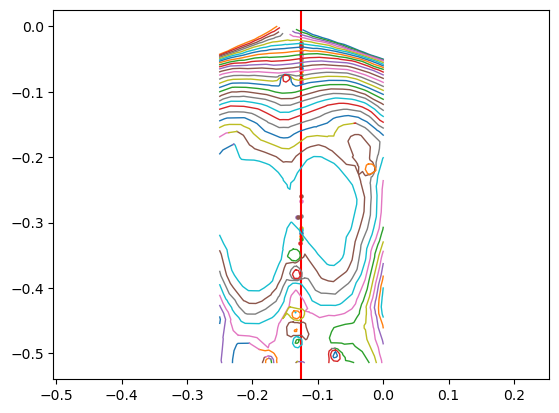

In [159]:
get_multiple().show()

AUC of right muscle using Trapezoidal rule = 0.041225799931648544
AUC of left muscle using Trapezoidal rule = -0.2227312061905093
AUC of right muscle using Simpson's rule = -0.6406567429312918
AUC of left muscle using Simpson's rule = 0.39126829640131244


C:\Users\antho\AppData\Local\Temp\ipykernel_15140\4067335670.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])


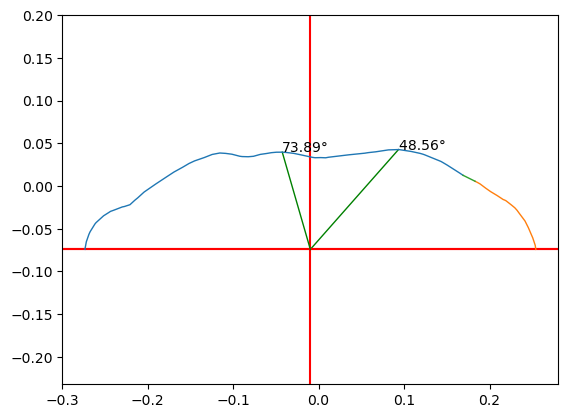

In [160]:
get_curves(curves="muscle")

In [161]:
vert = interset_mesh.vertices
fa = interset_mesh.faces
def get_max_rotate(degrees,axis):
  new_vert = []
  for v in vert:
    new_vert.append(rotate_vector(v,degrees,axis))
  # Create the mesh
  mesh_rot = trimesh.Trimesh(vertices= new_vert,
                       faces=fa)
  # return mesh_rot
  inter1 = trimesh.intersections.slice_mesh_plane(mesh_rot, [0,1,0], mesh_rot.centroid)
  inter2 = trimesh.intersections.slice_mesh_plane(inter1, [0,1,0], inter1.centroid)
  x = inter2.vertices[:,0]
  y = inter2.vertices[:,1]
  maxy = max(y)
  xpos = np.where(y == maxy)
  maxx = x[xpos]
  return maxy,maxx[0]

AUC of right muscle using Trapezoidal rule = 0.38995563658681126
AUC of left muscle using Trapezoidal rule = -0.45802949481705135
AUC of right muscle using Simpson's rule = -0.015532969174387179
AUC of left muscle using Simpson's rule = -0.7907925027468092


C:\Users\antho\AppData\Local\Temp\ipykernel_15140\4067335670.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])


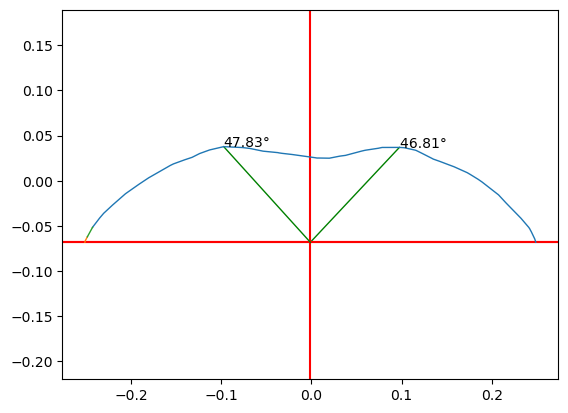

In [162]:
get_curves(curves="top")

Text(-0.2804711829112733, -0.2804711829112733, '0.43° ')

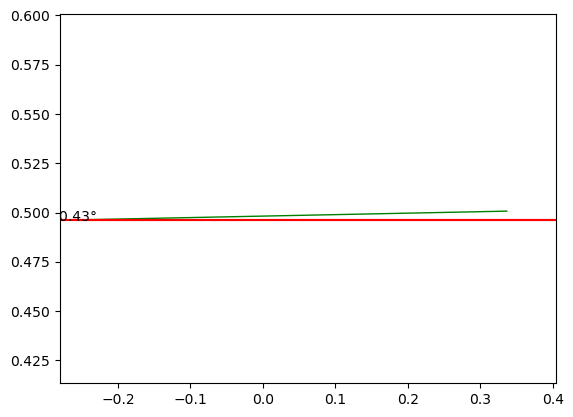

In [163]:
maxy,maxx = get_max_rotate(190,np.array([1,1,0]))
maxy1,maxx1 = get_max_rotate(180,np.array([1, -1, 0]))
if maxy > maxy1:
  maxy = maxy1
  maxy1 = maxy
ax = plt.gca()
ax.set_xlim((maxx ),(maxx1 * 1.2))
ax.set_ylim((maxy / 1.2 ),(maxy1 * 1.2))
line1 = Line2D([maxx,maxx1] , [maxy,maxy1],linewidth=1, linestyle = "-", color="green")
line2 = ax.axhline(y=maxy, color='r')
ax.add_line(line1)
ax.add_line(line2)
angle_plot = get_angle_plot(line1, line2, 1)
angle_text = get_angle_text(angle_plot)
angle_text = "%0.2f"%float(angle_text)+u"\u00b0" # Display angle upto 2 decimal places
text= "{} ".format(angle_text) 
ax.annotate(text,
              xy=(maxx, maxy), xycoords='data',
              xytext=(maxx, maxx), textcoords='offset points')


AUC of cervical spine using Trapezoidal rule = 24.27138509602831
AUC of thoracic muscle using Trapezoidal rule = -25.015301011652753
AUC of right muscle using Simpson's rule = 24.08369332610869
AUC of left muscle using Simpson's rule = -26.507393890682224


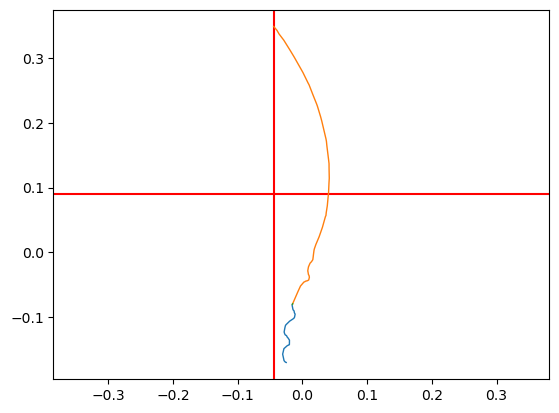

In [164]:
slice = rotated_back_slice()

In [165]:
# Check for negative numbers

def check_neg(list):
    for i in list:
        if i < 0: return True
    return False

0.010847379622360445


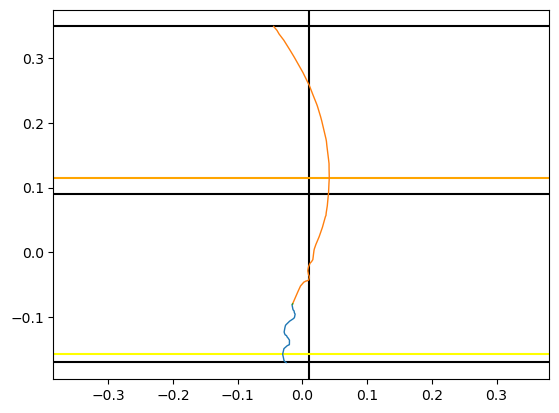

In [166]:
x = slice.vertices[:,0]
y = slice.vertices[:,1]
center_y = slice.centroid[1]

#INDEXES
above_centroid = np.where(y > center_y)
below_centroid = np.where(y < center_y)[0]
top = np.argmax(y)
bot = np.argmin(y)
thoracic_apex = np.argmax(x)
lumbar_apex = np.argmin(x[below_centroid])
lumbar_apex = np.where(x == x[below_centroid][lumbar_apex])[0][0]

ax = plt.gca()

midpoint = np.abs(x[thoracic_apex]) - np.abs(x[lumbar_apex])

# midpoint = x[top]
print(midpoint)

top_line = ax.axhline(y = y[top], color='black')
midpoint_line = ax.axvline(x = midpoint, color='black')
centroid_line = ax.axhline(y = center_y, color='black')
bot_line = ax.axhline(y = y[bot], color='black')
thoracic_apex_line = ax.axhline(y = y[thoracic_apex], color = 'orange')
lumbar_apex_line = ax.axhline(y = y[lumbar_apex], color='yellow')

slice.show()

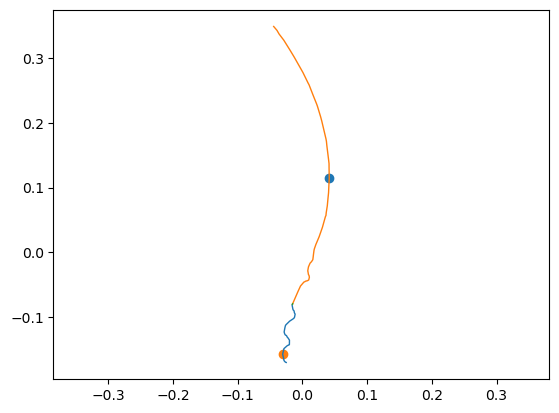

In [167]:
ax = plt.gca()

ax.scatter(x = x[thoracic_apex], y = y[thoracic_apex])
ax.scatter(x = x[lumbar_apex], y = y[lumbar_apex])
slice.show()

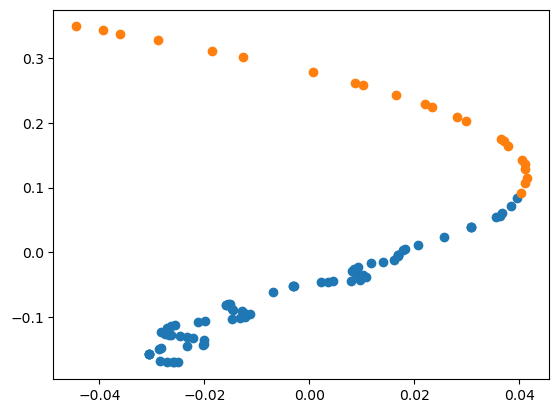

In [168]:
plt.scatter(x = x[below_centroid], y = y[below_centroid])
plt.scatter(x = x[above_centroid], y = y[above_centroid])

Top Spot:           (-0.044452980265730024, 0.34888122980804515)
Thoracic Apex Spot: (0.04143007781387717, 0.11443096978405426)
Centroid Spot:      (-0.0015114512259264273, 0.08932301007763195)
20.118628854565813
120.31487370210957
Theta: 79.80375515245625


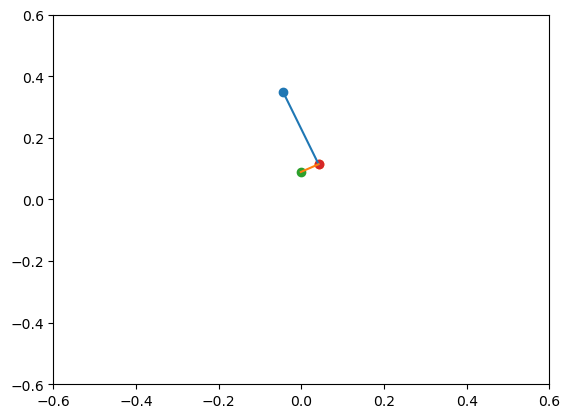

In [169]:
'''
Thoracic Kyphosis Angle calculation

Notes:
Top = T1
thoracic_apex = Apex
Centroid = T12
'''

top_spot = (x[top], y[top])
thoracic_apex_spot = (x[thoracic_apex], y[thoracic_apex])
centroid_spot = (slice.centroid[0], slice.centroid[1])
print(f'Top Spot:           {top_spot}')
print(f'Thoracic Apex Spot: {thoracic_apex_spot}')
print(f'Centroid Spot:      {centroid_spot}')

x1 = [thoracic_apex_spot[0], top_spot[0]]
y1 = [thoracic_apex_spot[1], top_spot[1]]

x2 = [thoracic_apex_spot[0], centroid_spot[0]]
y2 = [thoracic_apex_spot[1], centroid_spot[1]]

x1 = [top_spot[0], thoracic_apex_spot[0]]
y1 = [top_spot[1], thoracic_apex_spot[1]]

x2 = [centroid_spot[0], thoracic_apex_spot[0]]
y2 = [centroid_spot[1], thoracic_apex_spot[1]]

ax = plt.gca()
plt.xlim(-.6,.6)
plt.ylim(-.6,.6)

spot1 = ax.scatter(x1[0], y1[0])
spot2 = ax.scatter(x1[1], y1[1])
spot3 = ax.scatter(x2[0], y2[0])
spot4 = ax.scatter(x2[1], y2[1])

line1 = ax.plot(x1, y1)
line2 = ax.plot(x2, y2)

# θ = atan2(y2 - y1, x2 - x1)
angle1 = math.atan2(y1[1] - y1[0], x1[1] - x1[0]) * (180 / math.pi) + 90
print(f'{angle1}')
angle2 = math.atan2(y2[1] - y2[0], x2[1] - x2[0]) * (180 / math.pi) + 90
print(angle2)

# θ = 180° - |α - β|
theta = 180 - abs(angle1 - angle2)
print(f'Theta: {theta}')